# Dynamic Programming: Coin Changing Problem.

We are given a list of possible denominations $lst: [c_1, \ldots, c_k]$ and an amount $x$ for which we wish to make change.

Choose numbers of coins $n_1, \ldots, n_k$ of coins $c_1, \ldots, c_k$, respectively so that
  1. $n_1 c_1 + \ldots + n_k c_k = x$, i.e, we provide _exact_ change
  2. The number of coins $n_1 + \ldots + n_k$ is minimized.
  
 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
lst0 = [1, 4, 7, 9, 16, 43]
x0 = 33

## 1. Identify Optimal Substructure

To identify optimal substructure, we _stage_ our decisions. The decision to be made is what coins to provide as change.
We can stage these decisions as follows:
  1. Commit to providing a coin now. Let us say coin $c_i$.
  2. What remains then is how to provide change for $x - c_i$ using the minimum number of coins possible. In particular, we notice that the remaining problem is an instance of the original problem itself for a smaller amount.
  3. Once (2) is solved, we can append the coin $c_i$ from (1) to the set of coins that solve (2).
  
Therefore, we proceed to formulate a recursive function for the minimum number of coins.

## 2. Formulate a recurrence for the value

The recurrence $\text{minCoins}(x)$ takes in amount to change (it also has a parameter lst of the list of coins but let us leave it out for readability).

The recursive definition is 

$$\text{minCoins}(x) = \ \min\ \left\{ \begin{array}{ll}
1 + \text{minCoins}(x - c_1) & \leftarrow\ \ \text{use coin}\ c_1 \\
\vdots & \\
1 + \text{minCoins}(x - c_n) & \leftarrow\ \ \text{use coin}\ c_n \\
\end{array}\right.$$

The base cases are

  * $\text{minCoins}(0) = 0$
  * $\text{minCoins}(x) = \infty$ whenever $x < 0$. __Q:__ Interpret this base case!

In [2]:
def minCoins_recursive_1(x, lst):
    if x == 0: 
        return 0
    if x < 0:
        return 1000000 # A very large number!
    opts = [ 1 + minCoins_recursive_1(x - ci, lst) for ci in lst ]
    val = min(opts)
    return val

In [3]:
print(minCoins_recursive_1(17, lst0))
print(minCoins_recursive_1(23, lst0))
# CAUTION: This will take a minute or so to run!!  You may interupt it.
print(minCoins_recursive_1(42, lst0))

2
2
4


## Memoization

You already saw that the recursive function is prohibitively expensive. If you add a `print(x)` statement to the first line of the
function, you will see why. But beware of the size of the output!

To fix this, we use a memo table $T$ with entries $T[0], \ldots, T[x]$ where $x$ is the original amount we wish to make change for.
At each recursive call, when we wish to find out $\text{minCoins}(x - c_i)$, it will be simply read from the table as opposed to computed
afresh using a recursive call.



In [4]:
def minCoins_memoize_1(x, lst):
    T = [0]*(x+1) # make a list of all zeros of size x + 1
    for i in range(1,x+1):
        opts = [1 + T[i - cj] for cj in lst if (i - cj >= 0)]
        opts.append(10000000) # so that the list is not empty. Or else, the next line will throw an exception
        T[i] = min(opts)
    return T[x]

In [5]:
print(minCoins_memoize_1(17, lst0))
print(minCoins_memoize_1(23, lst0))
# Compare the running time to the recursive version :-)
print(minCoins_memoize_1(35, lst0))
print(minCoins_memoize_1(298, lst0))


2
2
4
10


## Solution Recovery

We have computed the number of coins needed, but how do we compute the actual coins themselves?

We augment the memo table not just to record the minimum value but also which coin gave us the minimum value. 

To do so, we make a new table $S[0], ... , S[x]$.

Once we have that recovering the set of coins involves yet another loop.

In [6]:
def minCoins_1(x, lst):
    T = [0] * (x+1) # memo table
    S = [-1]* (x+1) # best current/immediate decision
    coins_used = []
    for i in range(1,x+1):
        opts = [ (1 + T[i - cj], cj)  for cj in lst if i - cj >= 0]
        opts.append((1000000000, -1)) # Append + infinity to avoid min(..) raising an exception in the next line
        T[i], S[i] = min(opts)
    # NOW RECOVER the list of coins by using the S table.
    value_left = x
    while value_left > 0:
        coins_used.append(S[value_left])# append the immedidate decision
        value_left = value_left - S[value_left] # update the amount left
    assert value_left == 0
    return T[x], coins_used

In [7]:
print(minCoins_1(17, lst0))
print(minCoins_1(23, lst0))
# Compare the running time to the recursive version :-)
print(minCoins_1(35, lst0))
print(minCoins_1(298, lst0))

(2, [1, 16])
(2, [7, 16])
(4, [1, 9, 9, 16])
(10, [1, 7, 16, 16, 43, 43, 43, 43, 43, 43])


## Dynamic Programming Solution (Approach # 2)

As you can see from the previous approach: there are too many "repeated" decisions. The same coin is repeatedly used in multiple steps.
Suppose we stage the decision differently, we could formulate a different and perhaps faster function.

1. We are going to define a __recursive function__ $$minCoins(lst,x)$$ that will return the minimum number of coins needed to make change given $lst$ of coin denominations and $x$ the amount to make change for.

2. We will then make the recursive function efficient by using a  memo table.

3. We will show how from $minCoins(lst,x)$, we can also figure out the optimal way to give change.

### 0. Formulating the optimal substructure.

   1. Let $lst: [c_1, c_2, \ldots, c_j]$ and $x> 0$ be the amount to be changed. We will examine the coin $c_j$, the very last coin
   and decide how many times we are going to use the coin. This number $n_j$ can be between $0$ and $\lfloor \frac{x}{c_j} \rfloor$.
   2. Next, we will remove coin $c_j$ from further consideration and solve the problem for amount $x - n_j c_j$ with the new list of coins
   $lst: [c_1, \ldots, c_{j-1}]$.


### 1. Formulating the recursive function
<p>

Let $lst: [c_1, c_2, \ldots, c_j]$ and $x> 0$ be the amount to be changed. We will first work at the base cases of the recurrence $minCoins(lst,x)$

__Base Case #1 __  If $x = 0$, no amount needs to be changed. 
$minCoins(lst,0) = 0$.

<p>

__Base Case #2 __ If $x > 0$ but $lst = []$ is the empty list, then we have change to make but no coins to make change with, or alternatively only a fictitious 0 cent coins. This is an _undesirable situation_. Therefore, we set its value to $+\infty$.
$$minCoins(lst,x) = \infty,\ \text{if}\ lst = []\ \text{and}\ x > 0 $$ 

<p>

__Recursive Definition__ Assume that none of the base cases hold. Let $lst: [c_1, c_2, \ldots, c_j]$ and $x> 0$ be the amount to be changed.

Let us focus on the last entry $c_j$ of the list. 
1. We can decide to use the coin $c_j$ or not. 
2. More generally, if $p_j = \lfloor \frac{x}{c_j} \rfloor$, then we can choose to use $c_j$ not at all (0 times), once, twice, and so on all the way up to $p_j$ times. 
3. Once we commit to using the coin $c_j$ some number of times, we are left with the sub problem involving $lst': [c_1, \ldots, c_{j-1}]$ and a modified amount $x - s_j c_j$ if coin $c_j$ ended up being used $s_j$ times.


$$minCoins([c_1,\ldots,c_j],x):\ \min\ \begin{cases} 
minCoins([c_1,\ldots,c_{j-1}],x) & \leftarrow c_j\ \text{is not used at all} \\
1 + minCoins([c_1,\ldots,c_{j-1}], x- c_j) & \leftarrow c_j\ \text{is used once}\\
\vdots & \\
p_j + minCoins([c_1,\ldots,c_{j-1}], x - p_j c_j) & \leftarrow c_j\ \text{is used}\ p_j\ \text{times}\\
\end{cases}$$


<p>
The recurrence and bases cases above are directly implemented in python


    

In [8]:
def minCoinsRec(lst,x):
    j = len(lst) # the length of the list
    # Base case
    if (x == 0):
        return 0
    elif (j == 0): # List is empty
        return 100000000 # Return a really large number as a place holder for infinity.
    # Otherwise, implement the recursive function
    
    cj = lst[j-1] # the last element
    lst1 = lst[0:j-1] # all elements of the list but the last one
    pj = int(x/cj) # How many times can coin cj be used
    minValue = 100000000 #Initialize to a very large number
    for i in range(0,pj+1): # Includes both 0 and pj
        v = i + minCoinsRec(lst1, x - i * cj) # Make a recursive call
        if (v < minValue):
            minValue = v
    return minValue # Return the final answer

# Let us try it on the lst0 example above
j = minCoinsRec(lst0,x0)
print('Minimum number of coins needed for',lst0,'-->', j)


Minimum number of coins needed for [1, 4, 7, 9, 16, 43] --> 3


In [9]:
#Let us try it on a larger example, Careful -- this will not terminate anytime soon.
lst1=[1,2,4,8]
x1 = 4196

## Memoization

We just construct a table of all possible recursive calls and fill it in. 

If we go back to the minCoins recurrence, let $lst: [c_1,\ldots,c_n]$ be the original list and $x$ be the original amount.

1. Every subsequent call is of the form $\overline{lst}: [c_1,\ldots, c_j]$ for some $j \geq 0$ and some amount $0 \leq y < x$.

Let us make a 2D memo table where the rows are the amounts from $0, 1, 2, \ldots, x$ and the columns are values of $j$ from $j=0, 1, 2,\ldots, n$ denoting the lists $[c_1,\ldots,c_j]$. For $j=0$, we get the empty list.

$$\begin{array}{|c|c|c|c|c|c|}
\hline
   & [] & [c_1] & [c_1, c_2] & \cdots & [c_1, c_2, \ldots, c_{n-1}] & [c_1, \ldots, c_n] \\
   \hline
 0 & 0 & 0 & 0 &  \cdots &  0&  0\\
 1 & \infty & & & & & \\
 2 & \infty & & & & & \\
 \vdots & & & & \ddots & & \\
 x & \infty & & \cdots & & &  ?? \\
 \hline
\end{array}$$

The memo table has size $n \times x$ and we fill the table in starting from top left corner to the bottom right corner. The moment the bottom right corner is filled in, we have solved the original problem!


In [10]:
def minCoinsBottomUpMemoTable(lst,x):
    n = len(lst)
    # Create a memo table with (x+1) rows and (n+1) columns
    memoTbl =  [ [0 for i in range(0,n+1) ] for j in range(0,x+1) ]
    solutionTbl = [[ -1 for i in range(0,n+1)] for j in range(0,x+1)]
    # No need to fill in the 0s in the table
    for y in range(1,x+1):
        memoTbl[y][0] = 1000000
        for j in range(1,n+1):
            cj = lst[j-1]
            if (y < cj):
                memoTbl[y][j] = memoTbl[y][j-1]
                solutionTbl[y][j] = 0
            else:
                pj = int(y/cj)
                assert(pj > 0)
                minValue= 1000000
                bestOption = -1
                for i in range(0,pj+1):
                    l = i+memoTbl[y-i*cj][j-1]
                    if (l < minValue):
                        minValue = l
                        bestOption = i
                #Update memo table and solution tables
                memoTbl[y][j] = minValue
                solutionTbl[y][j] = bestOption
    # Done
    print('Minimum number of coins needed:', memoTbl[x][n])
    # Extracting solution
    j = n
    y = x
    while (y > 0 and j >= 0):
        k = solutionTbl[y][j]
        print('Coin:', lst[j-1], ' # Times:', k)
        y = y - k * lst[j-1]
        j = j -1
    
    

    

In [11]:
lst1
x1
minCoinsBottomUpMemoTable(lst1,x1)

Minimum number of coins needed: 525
Coin: 8  # Times: 524
Coin: 4  # Times: 1


In [12]:
def measureRunningTimeComplexity(fun,lst,x):
    t0 = time.perf_counter()
    fun(lst,x)
    t1 = time.perf_counter() # A rather crude way to time the process.
    return (t1 - t0)

[1] 9
Minimum number of coins needed: 9
Coin: 1  # Times: 9
[1, 2] 15
Minimum number of coins needed: 8
Coin: 2  # Times: 7
Coin: 1  # Times: 1
[1, 2, 4] 27
Minimum number of coins needed: 8
Coin: 4  # Times: 6
Coin: 2  # Times: 1
Coin: 1  # Times: 1
[1, 2, 4, 8] 51
Minimum number of coins needed: 8
Coin: 8  # Times: 6
Coin: 4  # Times: 0
Coin: 2  # Times: 1
Coin: 1  # Times: 1
[1, 2, 4, 8, 16] 99
Minimum number of coins needed: 8
Coin: 16  # Times: 6
Coin: 8  # Times: 0
Coin: 4  # Times: 0
Coin: 2  # Times: 1
Coin: 1  # Times: 1
[1, 2, 4, 8, 16, 32] 195
Minimum number of coins needed: 8
Coin: 32  # Times: 6
Coin: 16  # Times: 0
Coin: 8  # Times: 0
Coin: 4  # Times: 0
Coin: 2  # Times: 1
Coin: 1  # Times: 1
[1, 2, 4, 8, 16, 32, 64] 387
Minimum number of coins needed: 8
Coin: 64  # Times: 6
Coin: 32  # Times: 0
Coin: 16  # Times: 0
Coin: 8  # Times: 0
Coin: 4  # Times: 0
Coin: 2  # Times: 1
Coin: 1  # Times: 1


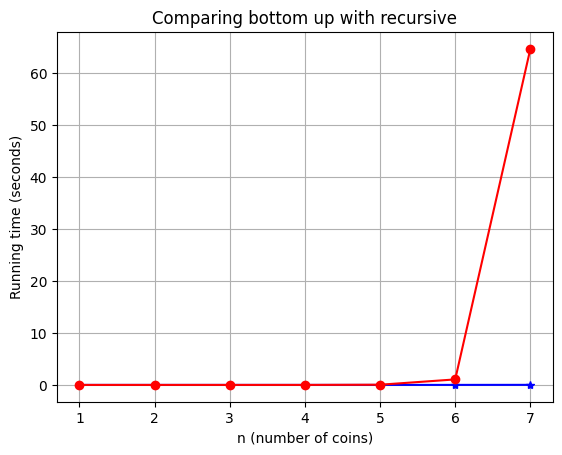

In [13]:
# Let us generate a plot of the running times
nList=[]
bottomUpTimes=[]
topDownTimes=[]
for i in range(1,8):
    lst=[2**j for j in range(0,i) ]
    x = 2**(i+1)+ 2**i+3
    print(lst,x)
    t1 = measureRunningTimeComplexity(minCoinsBottomUpMemoTable,lst,x)
    t2 = measureRunningTimeComplexity(minCoinsRec,lst,x)
    nList.append(i)
    bottomUpTimes.append(t1)
    topDownTimes.append(t2)


plt1=plt.plot(nList,bottomUpTimes,'-b*')
plt2=plt.plot(nList,topDownTimes,'-ro')
plt.xlabel('n (number of coins)')
plt.ylabel('Running time (seconds)')
plt.title('Comparing bottom up with recursive')
##plt.legend([plt1,plt2],['Bottom Up','Recursive'])
plt.grid(True)